#  House Prices - Advanced Regression Techniques
By Max Moacanin

## Introduction
In this notebook, I go through the steps I took to build and train a model for the "House Prices: Advanced Regression Techniques" Kaggle competition. The final model uses a combination of linear regression models with regularization and tree-based ensemble models. The final submission gets a score of 0.11473 on the competition leaderboard, which is currently good for 89th place out of 2,617 participants (top 4 percent).

## Outline
1. Import libraries
2. Read data
3. Exploratory data analysis
4. Remove Id variable
5. Target variable outliers
6. Log transformation of SalePrice
7. Handling missing data
8. Creating new features
9. Converting numeric variables to categorical
10. Converting categorical variables to numeric
11. Transforming skewed variables
12. Creating dummy variables
13. Modeling
    * Ridge regression
    * Lasso regression
    * Elastic Net regression
    * Random Forests
    * Gradient Boosting
    * XGBoost
    * Stacking
    * Finding the best combination of models
14. Submitting predictions

## 1. Import libraries

In [101]:
# General
import numpy as np 
import pandas as pd

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (9, 4)
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Warnings
import warnings
warnings.filterwarnings('ignore') # Supress any unnecessary warnings for readability

# Machine libraries
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p 

## 2. Read data

In [2]:
# Read the data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## 3. Exploratory data anlaysis
Let's begin by taking a look at the data. Specifically, I want to answer the following questions:

* What does the data set look like?
* How many features are in the raw data set?
* What is the distribution of the target variable (i.e. **SalePrice**)? Is it skewed?
* Which variables are most correlated with **SalePrice**?
* Are there any obvious outliers that should be removed from the training data?
* How are the variables related to each other?
* Are there a lot of missing data in the data sets (i.e. *both* the training data set and the submission data set)?
* Are any of the predictor variables skewed? If so, which ones? 

In [3]:
# First five rows in the training data
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# List of all the columns in the training data
train.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

Skewness: 1.883
Kurtosis: 6.536


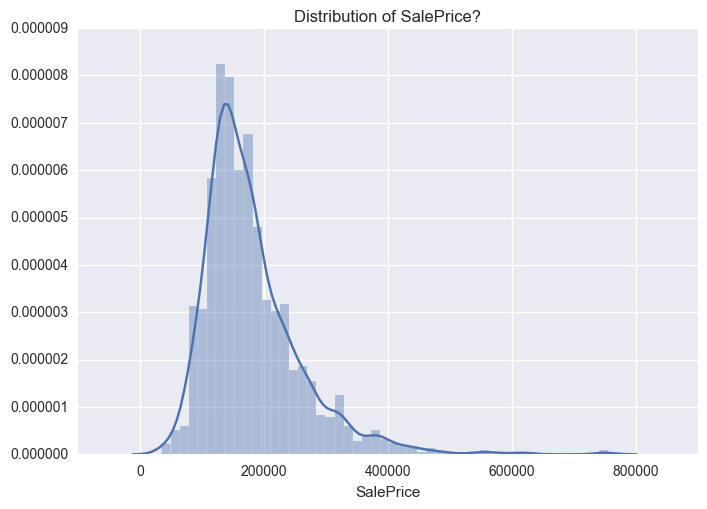

In [5]:
# Histogram w/ distribution of SalePrice
sns.distplot(train['SalePrice'])
plt.title('Distribution of SalePrice?');

# Print the skewness and kurtosis of SalePrice
print "Skewness: %.3f" % train['SalePrice'].skew()
print "Kurtosis: %.3f" % train['SalePrice'].kurt()

Skewness (log): 0.121
Kurtosis (log): 0.810


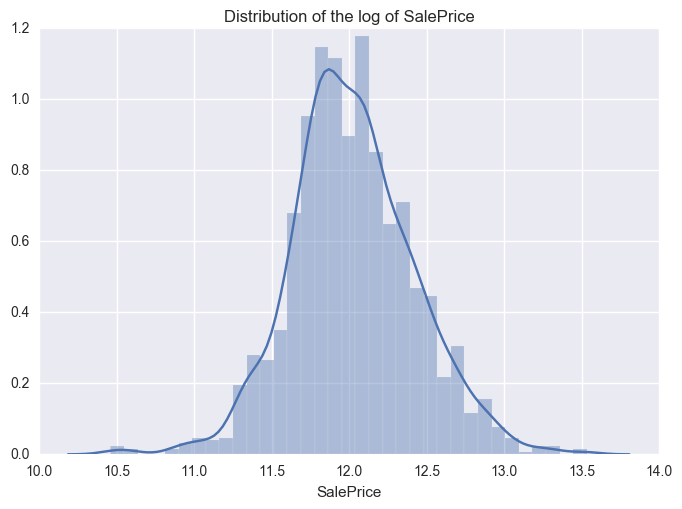

In [6]:
# Plot the SalesPrice data again using a log(1+x) transformation
sns.distplot(np.log1p(train['SalePrice'].astype(float)))
plt.title('Distribution of the log of SalePrice');
print "Skewness (log): %.3f" % np.log1p(train['SalePrice'].astype(float)).skew()
print "Kurtosis (log): %.3f" % np.log1p(train['SalePrice'].astype(float)).kurt()

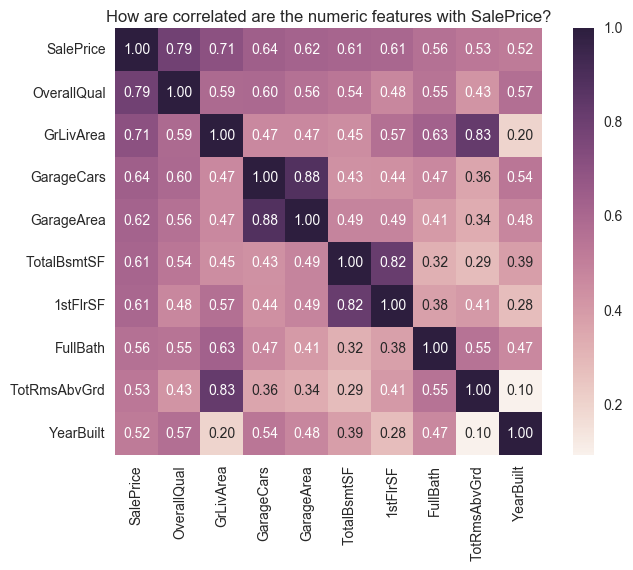

In [7]:
# Which numeric variables are most correlated with SalePrice?
k = 10 # Number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(
                    cm, 
                    cbar=True, 
                    annot=True, 
                    square=True, 
                    fmt='.2f', 
                    annot_kws={'size': 10}, 
                    yticklabels=cols.values, 
                    xticklabels=cols.values)
plt.title('How are correlated are the numeric features with SalePrice?')
plt.show()

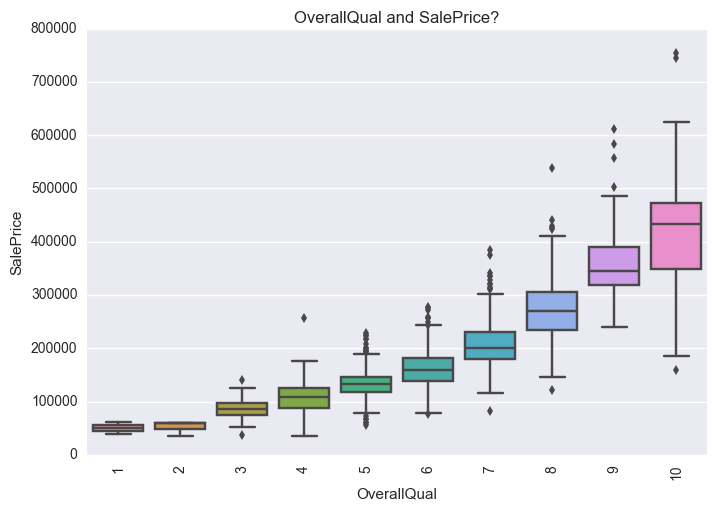

In [8]:
# Box plot of OverallQual (the most correlated variable)  vs. SalePrice
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
sns.boxplot(x='OverallQual', y='SalePrice', data=data)
plt.title('OverallQual and SalePrice?')
plt.xticks(rotation=90);

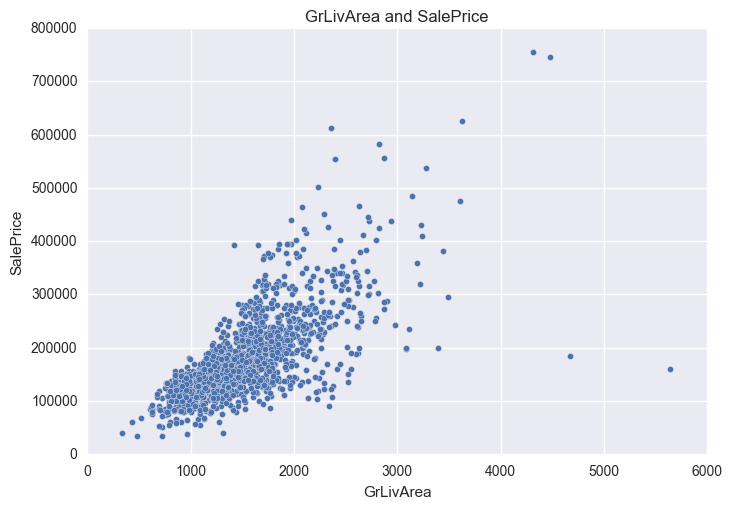

In [9]:
# Scatter plot of GrLivArea (2nd most corrleated variable) and SalePrice
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))
plt.title('GrLivArea and SalePrice');

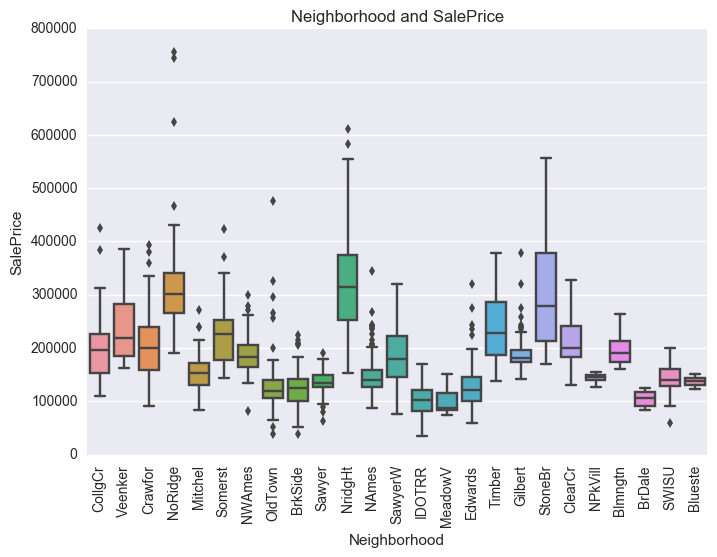

In [10]:
# Box plot of Neighborhood and SalePrice.
data = pd.concat([train['SalePrice'], train['Neighborhood']], axis=1)
sns.boxplot(x='Neighborhood', y='SalePrice', data=data)
plt.xticks(rotation=90)
plt.title('Neighborhood and SalePrice');

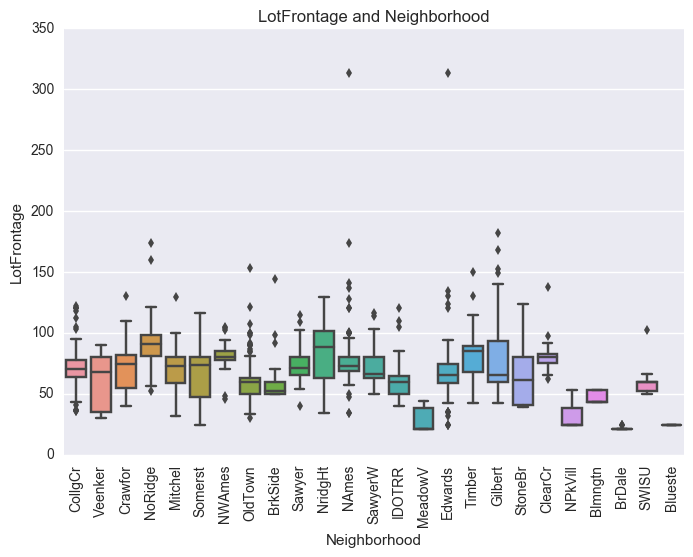

In [11]:
# Box plot of Neighborhood and LotFrontage.
data = pd.concat([train['LotFrontage'], train['Neighborhood']], axis=1)
sns.boxplot(x='Neighborhood', y='LotFrontage', data=data)
plt.title('LotFrontage and Neighborhood')
plt.xticks(rotation=90);

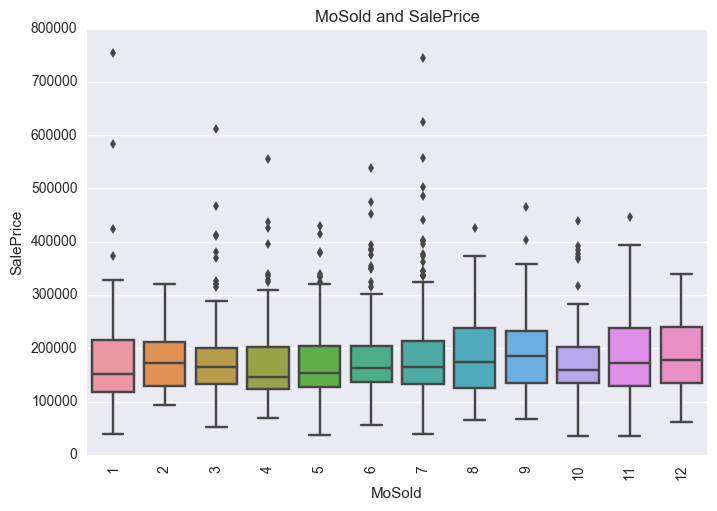

In [12]:
# Does the MoSold have an effect on SalePrice?
data = pd.concat([train['MoSold'], train['SalePrice']], axis=1)
sns.boxplot(x='MoSold', y='SalePrice', data=data)
plt.title('MoSold and SalePrice')
plt.xticks(rotation=90);

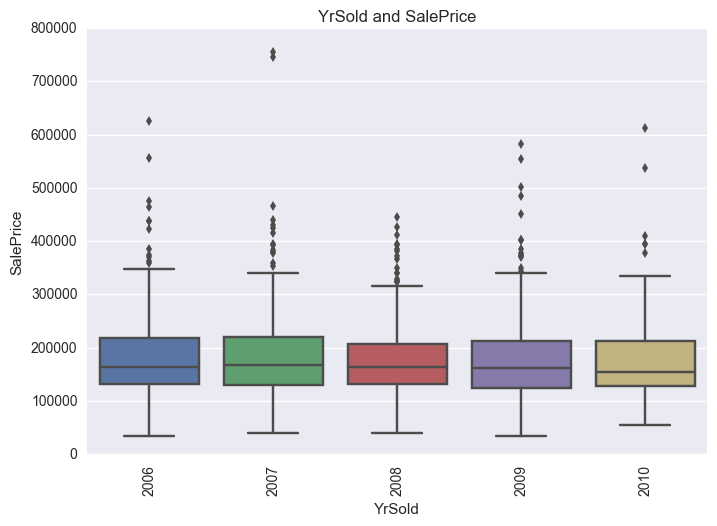

In [13]:
# Does YrSold have an effect on SalePrice?
data = pd.concat([train['YrSold'], train['SalePrice']], axis=1)
sns.boxplot(x='YrSold', y='SalePrice', data=data)
plt.title('YrSold and SalePrice');
plt.xticks(rotation=90);

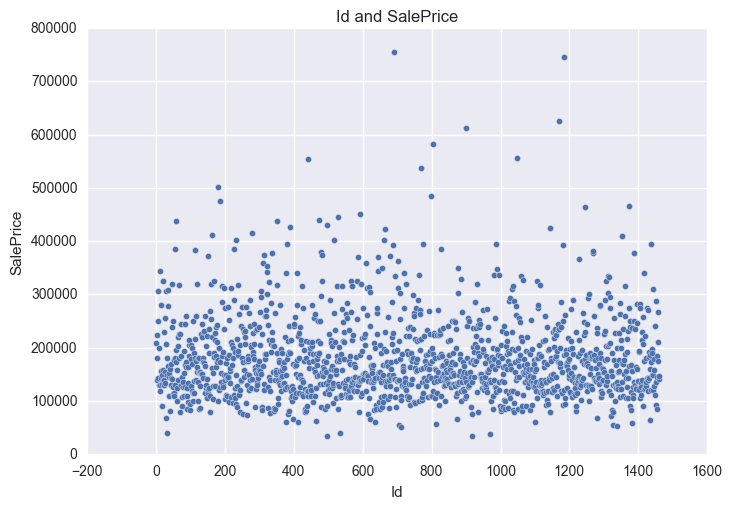

In [14]:
# Is the Id variable related to SalePrice at all? Or is it random?
data = pd.concat([train['SalePrice'], train['Id']], axis=1)
data.plot.scatter(x='Id', y='SalePrice', ylim=(0,800000))
plt.title('Id and SalePrice');

In [15]:
# Are there any missing data?

# Combine train and test data and remove SalePrice
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

# How prevalent are null values in these data sets
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
nulls = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
nulls = nulls[nulls['Total'] > 0]
nulls

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageCond,159,0.054471


In [16]:
# Are there any other skewed features besides SalePrice?
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_features = all_data[numeric_features].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
skewed = skewness.loc[(skewness.Skew > 0.5) | (skewness.Skew < -0.5)]
print "There are {} features with skewness greater than 0.5.".format(skewed.shape[0])
skewed

There are 27 features with skewness greater than 0.5.


,Skew
MiscVal,21.958480
PoolArea,16.907017
LotArea,12.829025
LowQualFinSF,12.094977
3SsnPorch,11.381914
KitchenAbvGr,4.304467
BsmtFinSF2,4.147456
EnclosedPorch,4.005950
ScreenPorch,3.948723
BsmtHalfBath,3.932018


## 4. Remove Id variable
The scatter plot of **Id** and **SalePrice** shows that the relationship between the two variables is random and that the **Id** variable most likely has no significant meaning in the data set. (It is not a reflection of when the house was sold, for example.) That said, we can remove it from the data sets.

In [17]:
# Store the Id column in separate variables -- use for indexing later
train_ID = train['Id']
test_ID = test['Id']

# Remove the Id variable from both the train and test sets
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## 5. Target variable outliers
The scatter plot of **SalePrice** and **GrLivArea** shows two observations that stand out as outliers. These two points, seen in the lower right hand corner of the graph, have unusually large values for **GrLivArea** given their relatively low values for **SalePrice**. The relationship between **SalePrice** and **GrLivArea** for these two houses does not match the relationship we see in the rest of the data. As a result, they should be removed from the training data. If they are not, they could have an undue influence on the final model.

In [18]:
# Removing the two points where GrLivArea > 4000 and SalePrice < 300000
train = train[(train['GrLivArea'] < 4000) | (train['SalePrice'] > 300000)]

## 6. Log transformation of SalePrice
The first histogram of the **SalePrice** variable shows that the variable is highly skewed (skewness = 1.883). The second histogram of the **SalePrice** variable shows that this issue can be resolved by taking log(1+x) of its values. This steps reduces its skewness to 0.121 and gives us a target variable that is normally distributed.

In [19]:
# Use np.log1p to apply log(1+x) to all elements in the SalePrice column
train["SalePrice"] = np.log1p(train["SalePrice"])

## 7. Handling missing data
The exploratory data analysis step also revealed that these data sets have a decent amount of missing data. This next step removes all of the missing data by imputing values for them. For specifics on how and why I went about doing this, see the comments in the code below.

In [20]:
# Combine training and testing set again. Needs to be updated because two
# outliers were removed from the training data.

# Store values that will be needed later
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

# Combine train and test data and remove SalePrice
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

##################
##### PoolQC #####
##################
'''If PoolArea == 0, then 'None'; 'Gd' for the only other null.'''
all_data.ix[(all_data.PoolQC.isnull()) & (all_data.PoolArea == 0), 'PoolQC'] = 'None'
all_data.ix[all_data.PoolQC.isnull(), 'PoolQC'] = 'Gd'


#######################
##### MiscFeature #####
#######################
'''If MiscFeature is null, then assume there are no miscellaneous features.'''
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')


#################
##### Alley #####
#################
'''If Alley is null, then assume there is no alley.'''
all_data.Alley = all_data.Alley.fillna('None')


#################
##### Fence #####
#################
'''If Fence is null, then assume there is no fence.'''
all_data.Fence = all_data.Fence.fillna('None')


#######################
##### FireplaceQu #####
#######################
'''All null observations for FireplaceQu are from houses with no fireplace.'''
all_data.FireplaceQu = all_data.FireplaceQu.fillna('None')


#####################
##### Utilities #####
#####################
'''Majority of the values are the same. Impute the mode.'''
all_data.Utilities = all_data.Utilities.fillna(all_data.Utilities.mode()[0])


######################
##### Functional #####
######################
'''Majority of the values are the same. Impute the mode.'''
all_data.Functional = all_data.Functional.fillna(all_data.Functional.mode()[0])

####################
##### SaleType #####
####################
'''Majority of the values are the same. Impute the mode.'''
all_data.SaleType = all_data.SaleType.fillna(all_data.SaleType.mode()[0])

######################
#### KitchenQual #####
######################
'''Only one missing value. Impute Gd, a common and middle value.'''
all_data.KitchenQual = all_data.KitchenQual.fillna("Gd")


#######################################
##### Exterior1st and Exterior2nd #####
#######################################
'''Impute "Other" for Exterior1st and Exterior2nd'''
all_data.Exterior1st = all_data.Exterior1st.fillna("Other")
all_data.Exterior2nd = all_data.Exterior2nd.fillna("Other")


######################
##### Electrical #####
######################
'''Only one missing value. Impute the mode.'''
all_data.Electrical = all_data.Electrical.fillna(all_data.Electrical.mode()[0])


####################################
##### Garage-related variables #####
####################################

# 1. First step: Impute "NoGarage" for all garage-related categorical variables where GarageArea == 0.'''
all_data.ix[all_data.GarageArea == 0, ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']] = 'None'

# 2. Assume there is no garage for the houses where GarageArea is null.'''
all_data.ix[all_data.GarageArea.isnull(), ['GarageType', 'GarageYrBlt', 'GarageFinish', 
                                       'GarageQual', 'GarageCond']] = 'None'
all_data.ix[all_data.GarageArea.isnull(), ['GarageArea', 'GarageCars']] = 0

# 3. One more observation: Use the YearBuilt for GarageYrBlt and the mode for the rest.'''
all_data.ix[all_data.GarageYrBlt.isnull(), 'GarageYrBlt'] = all_data[all_data.GarageYrBlt.isnull()].YearBuilt
all_data.GarageFinish = all_data.GarageFinish.fillna(all_data.GarageFinish.mode()[0])
all_data.GarageQual = all_data.GarageQual.fillna(all_data.GarageQual.mode()[0])
all_data.GarageCond = all_data.GarageCond.fillna(all_data.GarageCond.mode()[0])


######################################
##### Basement-related variables #####
######################################

# 1. Impute "NoBsmt" for the above variables when "TotalBsmtSF" is 0
bsmt_var_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
all_data.ix[all_data.TotalBsmtSF == 0, bsmt_var_cat] = 'None'
all_data.ix[all_data.TotalBsmtSF == 0, ['BsmtHalfBath', 'BsmtFullBath']] = 0.0

# 2. Assume that there is no basement if TotalBsmtSF is null
all_data.ix[all_data.TotalBsmtSF.isnull(), bsmt_var_cat] = 'None'
all_data.ix[all_data.TotalBsmtSF.isnull(), ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']] = 0.0

# 3. Impute the mode for the remaining missing values in the basement-related categorical variables.
all_data.ix[all_data.BsmtExposure.isnull(), 'BsmtExposure'] = all_data.BsmtExposure.mode()[0]
all_data.ix[all_data.BsmtQual.isnull(), 'BsmtQual'] = all_data.BsmtQual.mode()[0]
all_data.ix[all_data.BsmtCond.isnull(), 'BsmtCond'] = all_data.BsmtCond.mode()[0]
all_data.ix[all_data.BsmtFinType2.isnull(), 'BsmtFinType2'] = all_data.BsmtFinType2.mode()[0]


############################
##### MasVnr variables #####
############################

# 1. When the MasVnrType is null and the MasVnr Area is not null, impute the mode.
all_data.ix[(all_data.MasVnrType.isnull()) & (all_data.MasVnrArea.notnull()), 'MasVnrType'] = all_data.MasVnrType.mode()[0]

# 2. When both variables are null, impute "None" for MasVnr and 0.0 for MasVnrArea
all_data.MasVnrType = all_data.MasVnrType.fillna('None')
all_data.MasVnrArea = all_data.MasVnrArea.fillna(0.0)


####################
##### MSZoning #####
####################
'''Impute the mode for MSZoning whenever the data is missing.'''
all_data.MSZoning = all_data.MSZoning.fillna(all_data.MSZoning.mode()[0])


#######################
##### LotFrontage #####
#######################

Neighborhood_g = all_data['LotFrontage'].groupby(train['Neighborhood'])

for key,group in Neighborhood_g:
    # find where we are both simultaneously missing values and where the key exists
    LotFrontageNulls = all_data['LotFrontage'].isnull() & (all_data['Neighborhood'] == key)
    # fill in those blanks with the median of the key's group object
    all_data.loc[LotFrontageNulls,'LotFrontage'] = group.median()

## 8. Creating new features
After exploring the data, I decided to create a few new features based on the ones that were already available. I also decided to get rid of the **GarageYrBlt** variable because I did not think it would beneficial as either a numeric of categorical vairable.

In [21]:
# Create a feature for total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Create a feature for GrLivArea squared
all_data['GrLivArea2'] = all_data['GrLivArea'] ** 2

# Create a feature for OverallQual sqared
all_data['OverallQual2'] = all_data['OverallQual'] ** 2

# Create a feature for age when sold
all_data['AgeWhenSold'] = all_data['YrSold'].astype(int) - all_data['YearBuilt']

# Binary variable indicating whether or not the house was remodeled
all_data["Remodeled"] = (all_data["YearRemodAdd"] != all_data["YearBuilt"]) * 1

# Drop GarageYrBlt
all_data = all_data.drop(['GarageYrBlt'], axis=1)

## 9. Converting numeric variables to categorical
The following four numeric variables will better serve our final model if they are converted to categorical variables: **MSSubClass**, **OverallCond**, **YrSold**, **MoSold**.

In [22]:
# MSSubClass
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# OverallCond
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# YrSold and MoSold
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## 10. Converting categorical variables to numeric
There are a few categorical variables in this data set that contain ordinality. For example, many of the quality-related variables have the levels "Po", "Fa", "TA", "Gd", and "Ex" which contain implicit ordinality. These should be converted to numeric values their ordinality.

In [23]:
# Select columns that will be converted to numeric
cols = ( 
        
    # Basement variables
    'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure',
        
    # Garage variables
    'GarageQual', 'GarageCond', 'GarageFinish',
        
    # Other quality and condition variables
    'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'FireplaceQu', 'OverallCond', 
    
    # Other 
    'Functional', 'Fence',   'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass' 
)


# Apply the LabelEncoder to the categorical variables listed above
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

## 11. Transforming skewed variables
Next, I am going to transform the highly skewed predictor variables. Specifically, I am going to transform all predictor variables with an absolute skew value greater than 0.5 using a Box Cox transformation. I tried transforming the data using a log transformation, but the Box Cox transformation performed better in cross validation.

In [24]:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index
skewed_features = all_data[numeric_features].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
skewed = skewness.loc[(skewness.Skew > 0.5) | (skewness.Skew < -0.5)]
skewed_features = skewed.index

lam = 0.15  # Value that worked best during cross validation.
for feat in skewed_features:
    #all_data[feat] = np.log1p(all_data[feat])   # Tried this, but it did not perform as well in cross validation.
    all_data[feat] = boxcox1p(all_data[feat], lam)

## 12. Creating dummy variables
Lastly, I am going to create dummy variables for all the categorical variables in the data set. This will be especially beneficial for variables like **Neighborhood**, which are categorical and shown to have a significant effect on the **SalePrice**.

In [25]:
all_data = pd.get_dummies(all_data)

In [26]:
print "Columns in final data set: {}".format(all_data.shape[1])

Columns in final data set: 241


## 13. Modeling
Now that the data preprocessing steps are complete, I can begin to build models. The final training data set has a large number of features--241, to be exact. As a result, any algorithm that is fit to the entire training data will be highly susceptible to overfitting. That being said, I am going to explore linear regression models with various forms of regularization. Specifically, I am going to look at Ridge, Lasso, and Elastic Net regularizations.

Additionally, I am going to explore two tree-based ensemble methods: random forests and gradient boosting. For gradient boosting, I am going to try using both the sklearn library as well as the [XGBoost library](http://xgboost.readthedocs.io/en/latest/model.html).

When I have finished tuning and validating these models, I will combine the results from the best performers to create an ensemble model. This is what I will ultimately use to make my final submission to the Kaggle website.

*Quick note: Through trial and error, I found that removing the dummy variable for **MSZoning_C (all)** improved the final score on the submission set. That said, I will remove it in the next step.*

In [27]:
# Split the train and test sets again
train = all_data[:ntrain]
test = all_data[ntrain:]

# Training data set with all numeric features
X = train.select_dtypes(include=[np.number]).drop('MSZoning_C (all)', axis=1)

# Remove MSZoning_C (all) from the test data as well
X_test = test.select_dtypes(include=[np.number]).drop('MSZoning_C (all)', axis=1)

### Define a scoring function
The final predictions for the Kaggle competition are scored on the Root-Mean-Squared-Error between the logarithm of the predicted sale price and the logarithm of the actual sale price. I will do the same to score my models when using cross-validation.

In [28]:
# Define scoring function with RMSE for 5-fold cross-validation
def rmsle_CV(model):
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = 5))
    return rmse

### Ridge Regression
The first regression model that I am going to explore is **Ridge regression**. In ordinary linear regression, the objective is to minimize the residual sum of squares (RSS), i.e. the sum of the squared errors between the actual values and the values predicted by the model. Ridge regression differs from ordinary linear regression in that it performs L2 regularization, which adds a penalty equivalent to the square of the magnitude of coefficients. So, instead of minimizing the RSS like ordinary linear regression, Ridge regression minimizes the following:

\begin{equation*}
RSS + \alpha \times \left( \sum_{k=1}^n coefficients^2 \right)
\end{equation*}

As you can see in the equation above, there is a parameter, alhpa, that needs to be selected. Alpha balances the amount of emphasis given to minimizing RSS versus minimizing sum of square of coefficients. High values of alpha will place more emphasis on minimizing the sum of the squares of the coefficients; low values will place more emphasis on the RSS. If the value of alpha is 0, the minimization objective here will be identical to that in ordinary linear regression.

To decide on a value for alpha, I will do cross-validation using the RidgeCV function from the sklearn library. Specifically, I will do following:

1. Run cross-validation on a wide variety of values, ranging from 0.01 to 100.
2. Select the value for alpha that performed best during step 1. Define a new array of possible values for alpha that are centered around this value. These values will range from 0.6x and 1.4x the value selected in step 1.
3. Run cross-validation on this new array of values.
4. The best performing value from step 3 will serve as the value of alpha in the final ridge ression model.

In [29]:
# Define an wide array of alphas to test during cross-validation
ALPHAS = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 60, 100]

# Run cross-validation using RidgeCV
ridge = RidgeCV(alphas = ALPHAS, cv = 5)
ridge.fit(X, y_train)
alpha = ridge.alpha_

# What is the best alpha?
print "Best alpha:", alpha

Best alpha: 10


In [30]:
# Try get more precision for alpha by re-running CV with alphas centered around the best alpha from above.
print "Re-run CV with alphas centered around " + str(alpha)
scalars = np.arange(0.6, 1.45, 0.05)
ALPHAS = [alpha * i for i in scalars]
ridge = RidgeCV(alphas = ALPHAS, cv = 5)
ridge.fit(X, y_train)
alpha_final = ridge.alpha_
print "Alpha selected through cross validation:", alpha_final

Re-run CV with alphas centered around 10
Alpha selected through cross validation: 11.0


In [31]:
# Create final ridge regression model with selected alpha and RobustScalar
ridge = make_pipeline(RobustScaler(), Ridge(alpha=alpha_final))

In [32]:
# How well does this model perform during cross validation?
score = rmsle_CV(ridge)
print "The RMSE of the final Ridge regression during cross-validation is {:.4f}".format(score.mean())

The RMSE of the final Ridge regression during cross-validation is 0.1134


### Lasso Regression
The next regression model that I will explore is **Lasso (least absolute shrinkage and selection operator) regression**. Lasso regression is similar to Ridge regression in that it performs linear regression with regularization. Instead of L2 regularization, Lasso regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients.
Specifically, Lasso regression minimizes the following equation:

\begin{equation*}
RSS + \alpha \times \sum_{k=1}^n \lvert coefficients \rvert
\end{equation*}

One key distinction between Lasso and Ridge is that Lasso performs *both* and coefficient shrinkage and feature selection. Due to its optimization function, Lasso can make coefficients equal to zero, which is equivalent to the particular feature being excluded from the model.

Again, I will have to select a value for alpha and I will go about it using the same process I used for Ridge regression. (The only difference is that this time, I will use the **LassoCV** function provided by the sklearn library.)

In [33]:
# Define possible alphas for Linear Regression with Lasso regularization
ALPHAS = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]
lasso = LassoCV(alphas = ALPHAS, max_iter = 50000, cv = 5)
lasso.fit(X, y_train)
alpha = lasso.alpha_
print "Best alpha:", alpha

Best alpha: 0.0003


In [34]:
print "Re-run CV with alphas centered around " + str(alpha)
scalars = np.arange(0.6, 1.45, 0.05)
ALPHAS = [alpha * i for i in scalars]
lasso = LassoCV(alphas = ALPHAS, max_iter = 50000, cv = 5)
lasso.fit(X, y_train)
alpha_final = lasso.alpha_
print "Alpha selected through cross validation:", alpha_final

Re-run CV with alphas centered around 0.0003
Alpha selected through cross validation: 0.00027


In [35]:
# Fit a lasso model with optimized alpha and RobustScalar()
lasso = make_pipeline(RobustScaler(), Lasso(alpha = alpha_final))
score = rmsle_CV(lasso)
print "The RMSE of the final Lasso regression during cross-validation is {:.4f}".format(score.mean())

The RMSE of the final Lasso regression during cross-validation is 0.1111


### Linear Regression with Elastic Net Regularization
Lastly, I will take a look at linear regression with **Elastic Net** regularization. Elastic Net regularization is a method that linearly combines the L1 and L2 penalties of Lasso and Ridge regression. Specifically, Elastic Net regression minimizes the following equation:

\begin{equation*}
RSS + a \times L1 + b \times L2
\end{equation*}
where
\begin{equation*}\alpha = a + b\end{equation*} 
and 
\begin{equation*}
L1 ratio = \dfrac{a}{a+b}
\end{equation*}

To perform this type of regression, we will need to select values for alpha and the L1 ratio. (Side note: The L1 ratio must be between 0 and 1. If it is equal to 1, then elastic net regression is equivalent to Lasso regression; if it equals 0, it is equivalent to Ridge regression.) Once again, I will select these parameters using cross-validation in the same manner we did for both Ridge and Lasso regression.

In [36]:
L1_RATIOS = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
ALPHAS = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
elasticNet = ElasticNetCV(l1_ratio = L1_RATIOS,
                          alphas = ALPHAS, 
                          max_iter = 50000, cv = 5)
elasticNet.fit(X, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print "Best l1_ratio :", ratio
print "Best alpha :", alpha

Best l1_ratio : 0.9
Best alpha : 0.0003


In [37]:
print "Re-run the cross-validation with the l1_ratio centered around " + str(ratio)
scalars = np.arange(0.8, 1.25, 0.05)
L1_RATIOS = [ratio * i for i in scalars]
elasticNet = ElasticNetCV(l1_ratio = L1_RATIOS,
                              alphas = ALPHAS,
                              max_iter = 50000, cv = 5)
elasticNet.fit(X, y_train)
   
alpha = elasticNet.alpha_
ratio_final = round(elasticNet.l1_ratio_, 2)
print "Best l1_ratio :", ratio_final
print "Best alpha :", alpha

Re-run the cross-validation with the l1_ratio centered around 0.9
Best l1_ratio : 0.9
Best alpha : 0.0003


In [38]:
print "Re-run again for more precision on alpha, with l1_ratio fixed at " + str(ratio_final)
print "and alpha centered around " + str(alpha)

scalars = np.arange(0.6, 1.45, 0.05)
alphas = [alpha * i for i in scalars]
elasticNet = ElasticNetCV(l1_ratio = ratio_final,
                          alphas = ALPHAS, 
                          max_iter = 50000, cv = 5)
elasticNet.fit(X, y_train)
   
alpha_final = elasticNet.alpha_
ratio_final = elasticNet.l1_ratio_
print "Best l1_ratio :", ratio_final
print "Best alpha :", alpha_final

Re-run again for more precision on alpha, with l1_ratio fixed at 0.9
and alpha centered around 0.0003
Best l1_ratio : 0.9
Best alpha : 0.0003


In [39]:
# Fit a final elastic net model with the selected paramters and RobustScalar()
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=alpha_final, l1_ratio=ratio_final))
score = rmsle_CV(ENet)
print "The RMSE of the final Elastic Net model during cross-validation is {:.4f}".format(score.mean())


The RMSE of the final Elastic Net model during cross-validation is 0.1111


### Random Forest
Next, I am going to train a random forest model. Random forests are an ensemble method that can be used for both regression and classification problems. (For the purposes of this contest, I will be using it to perform regression.) Random forest models are created by taking a random subset of the observations and the features in the training data to build several decision trees which are then combined to create a final prediction. This prediction is usually made by either averaging them (regression) or taking a maximum vote (classification).

Random Forests have several parameters that need to be tuned to optimize its performance. In the steps below, I use grid search and cross-validation to select the optimal values for the following parameters: 

* **max_featuers** - the maximum number of features that can be used when building an individual decision tree.
* **n_estimators** - the number of decision trees that are built before we average the results to generate the prediction.
* **min_sample_leaf** - the minimum number of samples required to be at a leaf node

In [40]:
rfr = RandomForestRegressor()

param_grid = {
                'n_estimators' : [100, 500, 1000],
                'max_features' : ['auto', 'sqrt', 'log2'],
                'min_samples_leaf' : [50, 100]
              }

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
CV_rfr.fit(X, y_train)

print "Below are the parameters that were selected through cross-validation:"
print "max_features : {}".format(CV_rfr.best_params_['max_features'])
print "n_estimators : {}".format(CV_rfr.best_params_['n_estimators'])
print "min_samples_leaf : {}".format(CV_rfr.best_params_['min_samples_leaf'])

Below are the parameters that were selected through cross-validation:
max_features : auto
n_estimators : 1000
min_samples_leaf : 50


In [41]:
# Fit a random forest model with 
rf = make_pipeline(
                    RobustScaler(), 
                    RandomForestRegressor(
                                            max_features = CV_rfr.best_params_['max_features'],
                                            n_estimators = CV_rfr.best_params_['n_estimators'],
                                            min_samples_leaf = CV_rfr.best_params_['min_samples_leaf']
                                         )
                  )
score = rmsle_CV(rf)
print "The RMSE of the final random forest model during cross-validation is {:.4f}".format(score.mean())

The RMSE of the final random forest model during cross-validation is 0.1780


The RMSE for random forests during cross-validation is quite high relative to those from the models that used linear regression with regularization. That being said, it is unlikely that I will include the random forest model in my final prediction model.

### Gradient Boosting
Lastly, I am going to create two prediction models using Gradient Boosting--one using the sklearn library and one using the [XGBoost library](http://xgboost.readthedocs.io/en/latest/model.html), which provides an advanced implementation of a regular gradient boosting model.

Gradient boosting is similar to random forests in that it creates an ensemble of decision trees to solve either regression or classification problems. It is different from random forests because it is based on what are known as "weak learners." This means that it uses decision trees that are usually quite shallow, sometimes consisting of just two leaves. Random forest models, on the other hand, use fully grown trees. 

Additionally, gradient boosting builds its model in a stage-wise fashion. Random forests, on the other hand, build their models in parallel.

By using this "weak learners" approach, the individual trees in gradient boosting models have high bias and low variance. This means that, although they are unlikely to overfit to random noise (low variance), they are likely to miss a lot of relavent signal (high bias). Gradient boosting reduces bias by aggregating the results from several such trees.

An excellent guide to gradient boosting and parameter tuning can be found on Analytics Vidhya [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

### Tuning parameters in a Gradient Boosting model
Gradient Boosting models have a lot of paramters and thus, a decent amount of work is required to optimize them. For the purposes of this model, I am going to optimize the following parameters:

* **max_depth**
* **min_samples_leaf**
* **min_samples_split**
* **subsample**
* **n_estimators**
* **learning_rate**

I am going to tackle this optimization problem by using the same cross-validation process I used for the previous models. 

### max_depth and min_samples_leaf
The order of tuning variables is important; variables with a significant impact should be optimized first. That being said,
I am going to begin by simulataneously optimizing **max_depth**--the maximum depth of an individual tree--and **min_samples_leaf**--the minimum number of observations required for a terminal leaf in a tree.

In [43]:
# Select a wide array of parameters for max_depth & min_samples_leaf
params = {'max_depth' : [2, 10, 20, 50], 'min_samples_leaf' : [5, 10, 25, 50, 75, 100]}

# Run the GridSearchCV function on these arrays
gs = GridSearchCV(estimator=GradientBoostingRegressor(
                                                        
                                                        loss = 'huber', # Robust to outliers
                    
                                                        # Place holder values - will be tuned later
                                                        learning_rate = 0.05,
                                                        n_estimators = 3000,
                                                        max_features = 'sqrt',
                                                        subsample = 0.8,
                                                        random_state = 23
                                                    ),
                 param_grid = params)

gs.fit(X,y_train)



# What are the best performing parameters?
print "Best values after first iteration:"
print "max_depth:", gs.best_params_['max_depth']
print "min_samples_leaf:", gs.best_params_['min_samples_leaf']

Best values after first iteration:
max_depth: 2
min_samples_leaf: 10


In [44]:
# Update params array to center around those selected in previous step
params = {'max_depth' : range(1, 9), 'min_samples_leaf' : range(6, 15)}

# Re-run the grid search cross-validation with new parameters
gs = GridSearchCV(estimator=GradientBoostingRegressor(
                                                        loss = 'huber', # Robust to outliers
                                                        
                                                        # Place holder values - will be tuned later
                                                        learning_rate = 0.05,
                                                        n_estimators = 3000,
                                                        max_features = 'sqrt',
                                                        subsample = 0.8,
                                                        random_state = 23
                                                    ),
                 param_grid = params)
gs.fit(X,y_train)

# Store values in variable
max_depth_ = gs.best_params_['max_depth']
min_samples_leaf_ = gs.best_params_['min_samples_leaf']

# What are the final parameters that were selected?
print "Final selection for max_depth:", max_depth_
print "Final selection for min_samples_leaf:", min_samples_leaf_

Final selection for max_depth: 2
Final selection for min_samples_leaf: 7


### min_samples_split
Next, I am going to use the same approach to find the optimal value for **min_samples_split**, which is the minimum number of observations that a node is required to have to be considered for splitting. High values for this parameter will help prevent overfitting (low bias). However, if the value is too high, the model might miss a lot of relevant signal.

In [45]:
# Update params array
params = {'min_samples_split' : [4, 10, 25, 50, 100, 200]}

# Run the grid search cross-validation with new parameters
gs = GridSearchCV(estimator=GradientBoostingRegressor(
        
                                                        loss = 'huber', # Robust to outliers
        
                                                        # Place holder values - tuned later
                                                        learning_rate = 0.05,
                                                        n_estimators = 3000,
                                                        max_features = 'sqrt',
                                                        subsample = 0.8,
                                                        random_state = 23,
                                                        
                                                        # Selected from CV
                                                        max_depth = max_depth_, 
                                                        min_samples_leaf = min_samples_leaf_ 
                                                    ), 
                 param_grid = params)
gs.fit(X,y_train)



# What are the final parameters that were selected?
print "Best value for min_samples_split after first iteration:", gs.best_params_['min_samples_split']

Best value for min_samples_split after first iteration: 4


In [46]:
# Update params array and re-run grid search
params = {'min_samples_split' : range(2,9)}

# Run the grid search cross-validation with new parameters
gs = GridSearchCV(estimator=GradientBoostingRegressor(
                                                        
                                                        loss = 'huber', # Robust to outliers
        
                                                        # Place holder values - tuned later
                                                        learning_rate = 0.05,
                                                        n_estimators = 3000,
                                                        max_features = 'sqrt',
                                                        subsample = 0.8,
                                                        random_state = 23,
                                                        
                                                        # Selected from CV
                                                        max_depth = max_depth_,
                                                        min_samples_leaf = min_samples_leaf_
                                                    ),
                 param_grid = params)
gs.fit(X,y_train)

# Store selected value in variable
min_samples_split_ = gs.best_params_['min_samples_split']

# What are the final parameters that were selected?
print "Final selection for min_samples_split:", min_samples_split_

Final selection for min_samples_split: 2


### subsample
**subsample** is the fraction of observations that will be sampled for each tree. Values closer to one tend to make the model more robust by reducing variance.

Because the possible values for this parameters are bound between 0 and 1, I am only going to perform one iteration of the cross-validation process when selecting its value.

In [47]:
params = {'subsample' : np.arange(0.5, 1, .1)}

# Run the grid search cross-validation with new parameters
gs = GridSearchCV(estimator=GradientBoostingRegressor(
                                                        
                                                        loss = 'huber', # Robust to outliers
        
                                                        # Place holder value
                                                        learning_rate = 0.05,
                                                        n_estimators = 3000,
                                                        max_features = 'sqrt',
                                                        random_state = 23,
                                                        
                                                        # Selected from CV
                                                        max_depth = max_depth_, 
                                                        min_samples_leaf = min_samples_leaf_, 
                                                        min_samples_split = min_samples_split_ 
                                                    ),
                 param_grid = params)
gs.fit(X,y_train)

# Store the best performer in a variable
subsample_ = round(gs.best_params_['subsample'], 1)

# What are the final parameters that were selected?
print "Final selection for subsample:", subsample_

Final selection for subsample: 0.8


###  n_estimators
**n_estimators** represents the number of sequential trees to be modeled. Cross-validation is important when selecting a value for this parameter because too many trees can lead to the model overfitting.

In [48]:
params = {'n_estimators' : [500, 1000, 3000, 5000, 8000]}

# Run the grid search cross-validation with new parameters
gs = GridSearchCV(estimator=GradientBoostingRegressor(
                                                        
                                                        loss = 'huber', # Robust to outliers
        
                                                        # Place holder value                                                        
                                                        learning_rate = 0.05,
                                                        max_features = 'sqrt',
                                                        random_state = 23,
                                                        
                                                        # Selected from CV
                                                        max_depth = max_depth_, 
                                                        min_samples_leaf = min_samples_leaf_,
                                                        min_samples_split = min_samples_split_,
                                                        subsample = subsample_ 
                                                    ),
                 param_grid = params)
gs.fit(X,y_train)

# Store the best performing value in a variables
n_estimators_ = gs.best_params_['n_estimators']


# What are the final parameters that were selected?
print "Final selection for n_estimators:", n_estimators_

Final selection for n_estimators: 3000


### learning_rate
The **learning_rate** paramter determines the impact of each tree on the final outcome. Typically lower values for this parameter lead to better model performance because it makes the model robust to specific characteristics of the tree and thus allows the model to generalize well. However, lower values also require a higher number of trees in order to successfully model all the relationships between variables, which can be computationally expensive.

In [49]:
params = {'learning_rate' : np.arange(0.02, 0.2, 0.02)}

# Run the grid search cross-validation with new parameters
gs = GridSearchCV(estimator=GradientBoostingRegressor(
        
                                                        loss = 'huber', # Robust to outliers
        
                                                        # Place holder value
                                                        max_features = 'sqrt',
                                                        random_state = 23,
                                                        
                                                        # Selected from CV
                                                        max_depth = max_depth_,
                                                        min_samples_leaf = min_samples_leaf_,
                                                        min_samples_split = min_samples_split_,
                                                        subsample = subsample_,
                                                        n_estimators = n_estimators_
                                                    ),
                 param_grid = params)
gs.fit(X,y_train)

learning_rate_ = round(gs.best_params_['learning_rate'],2)

# What are the final parameters that were selected?
print "Best learning_rate:", learning_rate_

Best learning_rate: 0.02


Below are all of the paramter values that were selected during the cross-validation process:

* **max_depth** = 2
* **min_samples_leaf** = 7
* **min_samples_split** = 2
* **subsample** = 0.8
* **n_estimators** = 3000
* **learning_rate** = 0.02

Next, I am going to plug them all into the model and see how well it generalizes.

In [50]:
gradient_boosting = GradientBoostingRegressor(
                                                n_estimators=n_estimators_, 
                                                learning_rate=learning_rate_,
                                                max_depth=max_depth_, 
                                                max_features='sqrt', 
                                                subsample=subsample_,
                                                min_samples_leaf=min_samples_leaf_, 
                                                min_samples_split=min_samples_split_, 
                                                loss='huber', 
                                                random_state=23
                                            )

score = rmsle_CV(gradient_boosting)
print "\nRMSE: {:.4f}".format(score.mean())
print "SD: {:.4f}\n".format(score.std())


RMSE: 0.1088
SD: 0.0063



The RMSE for this model is 0.1088, which is even better than the scores that were obtained using regression with regularization.

Next, I am going to try XGBoost, or eXtreme Gradient Boosting, which is an advanced implementation of gradient boosintg. That said, it should produce a cross validation score that is *at least* as strong as that produced by gradient boosting.

### XGBoost
**XGBoost (eXtreme Gradient Boosting)**, as I mentioned,  is an advanced implementation of gradient boosting, the method used in the previous section to obtain a score of 0.1088 during cross validation.

The advantages of XGBoost over regular gradient boosting, as outlined in another [excellent blog post]( https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) on Analytics Vidhya, include: regularization, parallel processing, high flexibility, handling of missing values (which is not an issue for this post given that all missing values were taken care of in part 7 of this notebook), tree pruning and built-in cross-validation.

Like gradient boosting, XGBoost has a number of parameters that need to be tuned. I will go about selecting them using the same methods I used to select parameters for gradient boosting. There will be a lot of grid searching in this code, so it may take a while to run, depending on your system.

### max_depth and min_child_weight

In [51]:
params = {'max_depth' : np.arange(2,12,2), 'min_child_weight' : np.arange(0.5,5,0.5)}

model_xgb = xgb.XGBRegressor(                                
                             # Place holder values - will be tuned
                             learning_rate =0.1, 
                             n_estimators=1000,
                             gamma=0, 
                             subsample=0.5, 
                             colsample_bytree=0.8
                            )

# What are the best values for max_depth & min_child_weight?
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)

# Store the values in variables
max_depth_ = gs.best_params_['max_depth']
min_child_weight_ = gs.best_params_['min_child_weight']

print "Best values after first iteration:"
print "max_depth:", max_depth_
print "min_child_weight:", min_child_weight_

Best values after first iteration:
max_depth: 2
min_child_weight: 3.5


### gamma

In [52]:
params = {'gamma' : np.arange(0,0.5,0.1)}

model_xgb = xgb.XGBRegressor(
                             # Place holder values
                             n_estimators=1000, 
                             learning_rate=0.1,
                             subsample = 0.5,
                             colsample_bytree=0.8,

                             # Selected from CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_
                            )


# Fit the model and run GridSearchCV
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)

# Store value in variable
gamma_ = gs.best_params_['gamma']

# What's the best value?
print "Best value for gamma:", gamma_

Best value for gamma: 0.0


### subsample and colsample_bytree

In [53]:
params = {'subsample' : np.arange(0.6,1.0,0.1), 'colsample_bytree' : np.arange(0.6, 1.0, 0.1)}

model_xgb = xgb.XGBRegressor(
                             # Place holder values
                             n_estimators=1000, 
                             learning_rate=0.1,

                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_
                            )

# Fit the model and run GridSearchCV
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)

# Store values in variables
subsample_ = gs.best_params_['subsample']
colsample_bytree_ = gs.best_params_['colsample_bytree']

# What are the best values?
print "Best value for subsample:", subsample_
print "Best value for colsample_bytree_:", colsample_bytree_

Best value for subsample: 0.6
Best value for colsample_bytree_: 0.7


### learning_rate

In [54]:
params = {'learning_rate' : np.arange(0.01,0.3,0.01)}

model_xgb = xgb.XGBRegressor(
                             # Place holder for values
                             n_estimators=1000, 
 
                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_,
                             subsample = subsample_,
                             colsample_bytree = colsample_bytree_
                            )

# Fit the model and run GridSearchCV
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)

# What is the best value?
learning_rate_ =  gs.best_params_['learning_rate']
print "Best value for learning_rate:", learning_rate_

Best value for learning_rate: 0.06


### n_estimators

In [55]:
params = {'n_estimators' : np.arange(500, 4500, 500)}

model_xgb = xgb.XGBRegressor(
                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_,
                             subsample=subsample_,
                             colsample_bytree=colsample_bytree_,
                             learning_rate=learning_rate_
                            )

# What is the best value for n_estimators after the first iteration
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)
print "Best value for n_estimators after first iteration:", gs.best_params_['n_estimators']

Best value for n_estimators after first iteration: 1000


In [56]:
params = {'n_estimators' : np.arange(750, 1000, 1350)}

model_xgb = xgb.XGBRegressor( 
                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_,
                             subsample=subsample_,
                             colsample_bytree=colsample_bytree_,
                             learning_rate=learning_rate_
                            )


# Fit the model and run GridSearchCV
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)

# Store value in variable
n_estimators_ =  gs.best_params_['n_estimators']

# What is the final selection for n_estimators?
print "Final selection for n_estimators:", n_estimators_

Final selection for n_estimators: 750


### reg_alpha

In [57]:
params = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
    

model_xgb = xgb.XGBRegressor( 
                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_,
                             subsample=subsample_,
                             colsample_bytree=colsample_bytree_,
                             learning_rate=learning_rate_,
                             n_estimators=n_estimators_
                            )


# What is the best value for n_estimators after the first iteration
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)
print "Best value after first iteration:", gs.best_params_['reg_alpha']

Best value after first iteration: 0.01


In [58]:
params = {'reg_alpha':[0.001, 0.01, 0.025, 0.05, 0.075]}

model_xgb = xgb.XGBRegressor(  
                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_,
                             subsample=subsample_,
                             colsample_bytree=colsample_bytree_,
                             learning_rate=learning_rate_,
                             n_estimators=n_estimators_
                            )


# Fit the model and run GridSearchCV
gs = GridSearchCV(estimator = model_xgb, param_grid = params)
gs.fit(X, y_train)

# Store value in variable
reg_alpha_ = gs.best_params_['reg_alpha']

# What is the final selection for reg_alpha?
print "Final selection for reg_alpha:", reg_alpha_

Final selection for reg_alpha: 0.01


Below are the values that were selected for the XGBoost model during cross-vaidation:
* **max_depth** = 2
* **min_child_weight** = 3.5 
* **gamma** = 0
* **subsample** = 0.06
* **colsample_bytree** = 0.7
* **learning_rate** = 0.06
* **n_estimators** = 750
* **reg_alpha** = 0.01

In [59]:
model_xgb = xgb.XGBRegressor(
                             # Selected using CV
                             max_depth=max_depth_,
                             min_child_weight=min_child_weight_,
                             gamma=gamma_,
                             subsample=subsample_,
                             colsample_bytree=colsample_bytree_,
                             learning_rate=learning_rate_,
                             n_estimators=n_estimators_,
                             reg_alpha = reg_alpha_
                            )
score = rmsle_CV(model_xgb)
print "\nRMSE: {:.4f}".format(score.mean())
print "SD: {:.4f}\n".format(score.std())


RMSE: 0.1150
SD: 0.0088



### Generating predictions on the submission data

In [60]:
# Train models on the full training data
ridge_mod = ridge.fit(X, y_train)
lasso_mod = lasso.fit(X, y_train)
enet_mod = ENet.fit(X, y_train)
rf_mod = rf.fit(X, y_train)
gb_mod = gradient_boosting.fit(X, y_train)
xgb_mod = model_xgb.fit(X, y_train)

# Predict on the testing (submission) data
ridge_predict = np.expm1(ridge_mod.predict(X_test))
lasso_predict = np.expm1(lasso_mod.predict(X_test))
enet_predict = np.expm1(enet_mod.predict(X_test))
rf_predict = np.expm1(rf_mod.predict(X_test))
gb_predict = np.expm1(gb_mod.predict(X_test))
xgb_predict = np.expm1(xgb_mod.predict(X_test))

## How well does each model perform?
Next, I am going to run each individaul model on the testing data and submit the predictions to the official Kaggle competition. This will be beneficial for two reasons. One, it will allow me to doubel check that the models are generalizing well. It will be good to know, for example, if one of the models performs much worse on the Kaggle leaderboard than it did during cross-validation. Two, I will use these results as a guide when I determine how much weight to place on each model when I form my ensemble model that will ultimately be submitted as my final prediction.

In [63]:
### Ridge - 0.11795
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ridge_predict
submission.to_csv('ridge.csv', index=False)

### Lasso - 0.11834
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = lasso_predict
submission.to_csv('lasso.csv', index=False)

### Elastic Net - 0.11832
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = enet_predict
submission.to_csv('elastic_net.csv', index=False)

### Random Forest - 0.18760
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = rf_predict
submission.to_csv('random_forest.csv', index=False)

### Gradient Boosting - 0.11803
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = gb_predict
submission.to_csv('gradient_boosting.csv', index=False)

### XGBoost - 0.12029
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = xgb_predict
submission.to_csv('xgb.csv', index=False)


### LB Scores
* Ridge - 0.11795
* Lasso - 0.11834
* Elastic Net - 0.11832
* Random Forest - 0.18760
* Gradient Boosting - 0.12426
* XGBoost - 0.12029

In [64]:
# Compare predictions. How correlated are they?
results = {
                
                'gradient_boosting' : gb_predict,
                'ridge' : ridge_predict,
                'lasso' : lasso_predict,
                'enet' : enet_predict,
                'random_forest' : rf_predict,
                'xgb' : xgb_predict
          }

# Create results data frame
results_df = pd.DataFrame(results)

results_df.corr()

,enet,gradient_boosting,lasso,random_forest,ridge,xgb
enet,1.000000,0.991426,1.000000,0.926969,0.999563,0.988980
gradient_boosting,0.991426,1.000000,0.991418,0.938822,0.991233,0.995336
lasso,1.000000,0.991418,1.000000,0.926947,0.999557,0.988974
random_forest,0.926969,0.938822,0.926947,1.000000,0.926681,0.940065
ridge,0.999563,0.991233,0.999557,0.926681,1.000000,0.988687
xgb,0.988980,0.995336,0.988974,0.940065,0.988687,1.000000


The predicitons from the six learning algorithms are all quite highly correlated with one another.

### Stacking Models

In [65]:
from sklearn.model_selection import KFold

def stackModels(base_models, meta_model):
    
    # Initialize arrays
    base_models_ = [list() for x in base_models]
    out_of_fold_predictions = np.zeros((X.shape[0], len(base_models)))
    kfold = KFold(n_splits=5, shuffle=True, random_state=156)
    
    # Generate predictions on hold out set
    for i, model in enumerate(base_models):
        for train_index, holdout_index in kfold.split(X, y_train):
            model.fit(X.ix[train_index], y_train[train_index])
            y_pred = model.predict(X.ix[holdout_index])
            out_of_fold_predictions[holdout_index, i] = y_pred
    
    # Fit the meta model with the predictions from the base models
    meta_model.fit(out_of_fold_predictions, y_train)
    
    # Create features for meta model
    meta_features = np.column_stack([
        np.column_stack([model.predict(X_test) for model in base_models]).mean(axis=1)
            for base_models_ in base_models_ ])
    
    # Generate predictions
    final_predictions = np.expm1(meta_model.predict(meta_features))
    
    # Return predictions
    return final_predictions

In [81]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
stack_predictions = stackModels(base_models = (ridge, ENet, lasso, gb_mod), meta_model=lr) # 0.11755

In [82]:
# Official submisssion file for stacking - 0.11755
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = stack_predictions
submission.to_csv('stacking.csv', index=False)

The stacking method I used here using Ridge, Elastic Net, Lasso, and Gradient Boosting as the base models and linear regression as the meta model performs quite well. It gets a score of 0.11755 on the leaderboard, which is better than any of the models gets on its own.

### Finding the best combination of models

In [99]:
#final_predictions = (xgb_predict + ridge_predict + gb_predict)/3 # 0.11494
#final_predictions = .3*xgb_predict + .3*ridge_predict + .4*gb_predict # 0.11501
#final_predictions = (xgb_predict + gb_predict + stack_predictions)/3 # 0.11557
#final_predictions = .4*xgb_predict + .3*ridge_predict + .3*gb_predict # 0.11514
#final_predictions = .275*xgb_predict + .45*ridge_predict + .275*gb_predict # 0.11476
#final_predictions = .25*xgb_predict + .5*ridge_predict + .25*gb_predict # 0.11477
final_predictions = .22*xgb_predict + .45*ridge_predict + .33*gb_predict # 0.11473

Through a little bit of trial and error, I found that the best performing combination was to simply to take a weighted average of the XGBoost, Ridge, Gradient Boosting models, giving 22 percent of the weight to XGBoost, 45 percent to the Ridge model, and 33 percent to the Gradient Boosting model. This ultimately results in a score of 0.11473 on the official leaderboard, which puts it in the top 4 percent of submissions. Not bad!

## 14. Submitting Predictions

In [100]:
# Official submisssion file
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = final_predictions
submission.to_csv('weighted_ridge_xgb_gb.csv', index=False)